In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import torchmetrics
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [2]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

2024-05-09 11:18:45.869268: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 11:18:47.097062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 100
experiment_name = 'lucas_01'
print('device:', device)

device: cuda


In [4]:
df_train = pd.read_csv('data/lucas_dataset_train.csv')
df_val = pd.read_csv('data/lucas_dataset_val.csv')
df_test = pd.read_csv('data/lucas_dataset_test.csv')

In [5]:
print(df_train.shape)
df_train

(13939, 4216)


,Unnamed: 0,spc.400,spc.400.5,spc.401,spc.401.5,spc.402,spc.402.5,spc.403,spc.403.5,spc.404,...,sand,pH.in.CaCl2,pH.in.H2O,OC,CaCO3,N,P,K,CEC,set
0,5671,0.669077,0.676745,0.684369,0.691928,0.699396,0.706758,0.713992,0.721079,0.728002,...,75,4.78,5.15,8.2,0,0.9,39.6,54.6,2.8,2
1,9008,0.679681,0.687950,0.696161,0.704279,0.712283,0.720136,0.727818,0.735309,0.742584,...,41,4.33,4.84,44.1,0,2.5,54.2,261.8,13.8,1
2,9941,0.786848,0.795459,0.804018,0.812496,0.820865,0.829104,0.837181,0.845079,0.852777,...,48,6.08,6.67,22.6,0,2.3,29.1,216.5,12.8,1
3,345,0.583825,0.592186,0.600491,0.608715,0.616834,0.624822,0.632655,0.640310,0.647767,...,35,4.67,5.58,21.0,0,1.5,0.0,69.8,4.7,1
4,4307,0.791126,0.799194,0.807208,0.815131,0.822943,0.830612,0.838116,0.845435,0.852549,...,50,6.77,7.04,38.8,6,3.0,12.1,54.3,20.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13934,8155,0.642357,0.650594,0.658771,0.666853,0.674813,0.682620,0.690251,0.697683,0.704898,...,86,3.72,4.66,10.3,0,0.3,15.5,21.0,3.0,3
13935,1636,0.922261,0.934263,0.946202,0.958037,0.969738,0.981275,0.992614,1.003729,1.014598,...,22,7.01,7.69,11.3,2,1.0,0.0,458.5,22.6,3
13936,5012,0.705685,0.712331,0.718935,0.725476,0.731939,0.738299,0.744541,0.750645,0.756600,...,89,3.09,3.95,9.3,0,0.4,0.0,20.3,4.7,1
13937,3820,0.821155,0.831790,0.842372,0.852866,0.863251,0.873497,0.883579,0.893470,0.903146,...,53,7.02,7.68,6.2,1,0.7,0.0,466.0,17.1,1


### Get X and y of train and val

In [6]:
# Logical array of columns
# input_cols = df_train.columns.str.contains('spc') | df_train.columns.str.contains('GPS')
input_cols = df_train.columns.str.contains('spc')
drop_cols = ['Unnamed: 0', 'set', 'GPS_LAT', 'GPS_LONG']

X_train = df_train[df_train.columns[input_cols]]
y_train = df_train[df_train.columns[~input_cols]].drop(drop_cols, axis=1)
X_val = df_val[df_val.columns[input_cols]]
y_val = df_val[df_val.columns[~input_cols]].drop(drop_cols, axis=1)
X_test = df_test[df_val.columns[input_cols]]
y_test = df_test[df_val.columns[~input_cols]].drop(drop_cols, axis=1)

print(X_train.columns[-2:])
print(X_train.shape)
print('nan ', X_train.iloc[:, -2:].isna().sum())

nr_output_features = y_train.shape[1]
nr_input_features = X_train.shape[1]
print('nr_output_features:', nr_output_features, '\nnr_input_features:', nr_input_features)

output_features_names = np.array(y_train.columns)
print(output_features_names)

Index(['spc.2499', 'spc.2499.5'], dtype='object')
(13939, 4200)
nan  spc.2499      0
spc.2499.5    0
dtype: int64
nr_output_features: 12 
nr_input_features: 4200
['coarse' 'clay' 'silt' 'sand' 'pH.in.CaCl2' 'pH.in.H2O' 'OC' 'CaCO3' 'N'
 'P' 'K' 'CEC']


### Scale X and y

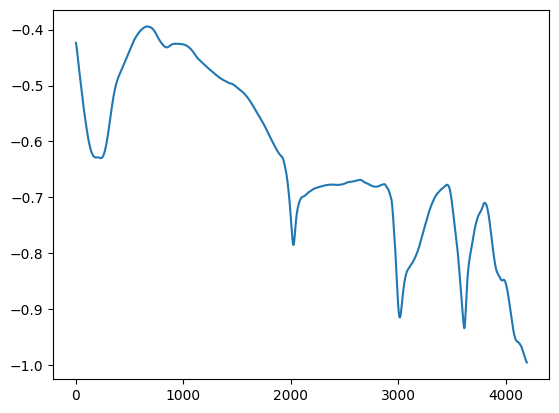

In [7]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)
y_train = y_scaler.fit_transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)

plt.plot(X_train[1, :-2])
plt.show()

### Load train and validation dataset

In [8]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df, target, contains_GPS=True):
        self.data = torch.tensor(df, dtype=torch.float32).unsqueeze(1) # unsqueeze to add channel dimension
        self.data = self.data.expand(-1, 5, -1).clone() # expand to add features dimension
        unscaled_data = X_scaler.inverse_transform(self.data[:, 0, :])

        self.data[:, 1, :] = torch.log(1 / torch.tensor(unscaled_data, dtype=torch.float32)) # Absorbance

        if contains_GPS:
            self.data[:, 1, -2:] = torch.tensor(unscaled_data[:, -2:], dtype=torch.float32) # GPS data

        first_derivative = torch.gradient(self.data[:, 1, :], dim=1)[0]
        second_derivative = torch.gradient(first_derivative, dim=1)[0]
        mean = torch.mean(self.data[:, 1, :], dim=0)
        std = torch.std(self.data[:, 1, :], dim=0)
        
        self.data[:, 2, :] = first_derivative # Absorbance + 1st derivative
        self.data[:, 3, :] = second_derivative # Absorbance + 2nd derivative
        self.data[:, 4, :] = self.data[:, 1, :] + (self.data[:, 1, :] - mean) / std # Absorbance + normalized absorbance
        self.target = torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        # here i will return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]


In [9]:
train_ds = Dataset(X_train, y_train)
val_ds = Dataset(X_val, y_val)
test_ds = Dataset(X_test, y_test)

nr_features = len(train_ds)
nr_features

13939

torch.Size([5, 4200])
torch.Size([12])


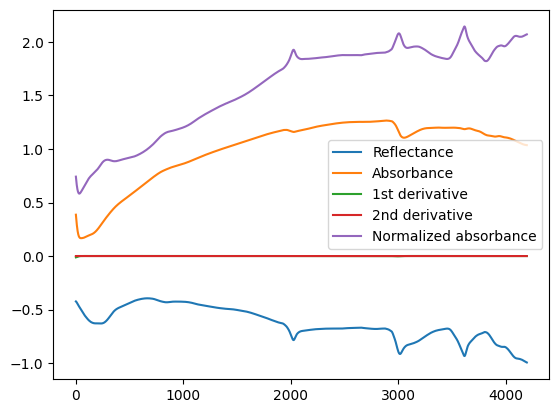

In [10]:
# get first item
inp, out = train_ds.__getitem__(1)
# print shapes
print(inp.shape)
print(out.shape)
plt.plot(inp[0, :-4])
plt.plot(inp[1, :-4])
plt.plot(inp[2, :-4])
plt.plot(inp[3, :-4])
plt.plot(inp[4, :-4])
plt.legend(['Reflectance', 'Absorbance', '1st derivative', '2nd derivative', 'Normalized absorbance'])
plt.show()

### Create train and validation dataloader

In [11]:
# create train dataloader
trainloader = torch.utils.data.DataLoader(
    train_ds,
    batch_size = batch_size,
    drop_last = True,
    shuffle = True,
    num_workers = 8
)
# create validation dataloader
valloader = torch.utils.data.DataLoader(
    val_ds,
    batch_size = batch_size,
    drop_last = False,
    shuffle = False,
    num_workers = 8
)
testloader = torch.utils.data.DataLoader(
    test_ds,
    batch_size = batch_size,
    drop_last = False,
    shuffle = False,
    num_workers = 8
)

### Define network

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv1d(5, 64, kernel_size=3, stride=1, padding=1),      
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),

            # nn.MaxPool1d(kernel_size=3, stride=3, padding=1),          # 4200 -> 1400
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),          # 4200 -> 2100
            
            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1),      
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            
            # nn.MaxPool1d(kernel_size=3, stride=3, padding=1),           # 1400 -> 466
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),           # 2100 -> 1050

            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),      
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            # nn.MaxPool1d(kernel_size=3, stride=3, padding=1),           # 466 -> 156
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),           # 1050 -> 525
            
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),    
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            # nn.MaxPool1d(kernel_size=3, stride=3, padding=1),           # 156 -> 52
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),           # 525 -> 262
            
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),    
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),

            # nn.MaxPool1d(kernel_size=3, stride=3, padding=1),           # 52 -> 18
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),           # 262 -> 131
            
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),    
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),

            # nn.MaxPool1d(kernel_size=3, stride=3, padding=1),           # 18 -> 6
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),           # 131 -> 66
            
            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512 * 67, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(1024, 64),
            nn.Dropout(0.5),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 12),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

net = Net()
net.to(device)

Net(
  (features): Sequential(
    (0): Conv1d(5, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (12): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(128, eps=1e-05, momentum=0

In [13]:
from torchsummary import summary
summary(net, (5, 4200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 4200]           1,024
       BatchNorm1d-2             [-1, 64, 4200]             128
         LeakyReLU-3             [-1, 64, 4200]               0
         MaxPool1d-4             [-1, 64, 2101]               0
            Conv1d-5             [-1, 64, 2101]          12,352
       BatchNorm1d-6             [-1, 64, 2101]             128
         LeakyReLU-7             [-1, 64, 2101]               0
         MaxPool1d-8             [-1, 64, 1051]               0
            Conv1d-9            [-1, 128, 1051]          24,704
      BatchNorm1d-10            [-1, 128, 1051]             256
        LeakyReLU-11            [-1, 128, 1051]               0
        MaxPool1d-12             [-1, 128, 526]               0
           Conv1d-13             [-1, 128, 526]          49,280
      BatchNorm1d-14             [-1, 1

Define a loss function and optimizer

Let's use a Regression [L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) loss and [ADAM](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) optimizer. [learning rate scheduler](https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863#fad1)



In [14]:
import torch.optim as optim  # Optimization algorithms for training the model
from scipy.stats import spearmanr, pearsonr  # Statistical functions for correlation calculation
import itertools  # Utility functions for generating combinations
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler for training


# Define training parameters (epochs, loss function, optimizer, and scheduler)
epochs = 50  # Number of training epochs
# criterion = F.mse_loss()  # L1 loss function for regression (mean absolute error)
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
scheduler = CosineAnnealingLR(optimizer,
                              T_max=len(trainloader) * epochs,  # Maximum number of iterations for scheduler
                              eta_min=1e-5)  # Minimum learning rate for scheduler

class RMSELoss(nn.Module):
    def __init__(self, eps=1e-9):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    
rmse_loss = RMSELoss()

### Define train and validate function

In [15]:
def train(net, train_loader, verbose=False):
    net.train()
    running_loss = 0.0
    for inputs, gt in train_loader:
        inputs = inputs.to(device)
        gt = gt.to(device)

        optimizer.zero_grad()
        out = net(inputs)
        loss = F.mse_loss(out, gt)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def validate(net, val_loader, verbose=False):
    net.eval()
    val_loss = 0
    losses = []
    for inputs, gt in val_loader:
        inputs = inputs.to(device)
        gt = gt.to(device)

        with torch.no_grad():
            out = net(inputs)
            loss = F.mse_loss(out, gt)
            val_loss += loss.item()
            losses.append(loss.item())
    if verbose:
        print(f'Loss: {np.mean(losses):.4f}, std: {np.std(losses):.4f}, min: {np.min(losses):.4f}, max: {np.max(losses):.4f}')

    return val_loss / len(val_loader)

def exit_condition(best_value, running_loss, val_loss, epoch, no_improv):
    if best_value is None or running_loss < best_value:
        best_value = running_loss
        torch.save(net.state_dict(), f'./models/{experiment_name}.pth')
        no_improv = 0

    # Early stopping due to overfitting
    if running_loss < val_loss * 0.9 and epoch > 20:
        print('Early stopping due to overfitting')
        return True
    if running_loss > best_value:
        no_improv += 1
        if no_improv > 10:
            print('Early stopping due to no improvement')
            return True

### Perform training with fine-tuning

In [16]:
best_value = None
no_improv = 0

try:
    pbar.close()
except:
    pass

pbar = tqdm(total=epochs, desc='Training', leave=False, unit='epoch', ncols=150) # Progress bar for training

for epoch in range(epochs):

    running_loss = train(net, trainloader)

    val_loss = validate(net, valloader)

    writer.add_scalar('Epoch', epoch, epoch)
    writer.add_scalars('Loss/epoch', {'train': running_loss, 'val': val_loss}, epoch)

    if best_value is None or running_loss < best_value:
        best_value = running_loss
        torch.save(net.state_dict(), f'./models/{experiment_name}.pth')
        no_improv = 0

    # Early stopping due to overfitting
    if running_loss < val_loss * 0.9 and epoch > 20:
        print('Early stopping due to overfitting')
        break
    if running_loss > best_value:
        no_improv += 1
        if no_improv > 10:
            print('Early stopping due to no improvement')
            break

    pbar.set_description(f'Train Loss: {running_loss:.4f} - Val Loss: {val_loss:.4f} Best loss: {best_value:.4f} - No improv: {no_improv}')

    pbar.update(1)

pbar.close()
writer.close()

Training:   0%|                                                                                                             | 0/50 [00:00<?, ?epoch/s]

Train Loss: 0.4663 - Val Loss: 0.3787 Best loss: 0.4663 - No improv: 0:  40%|███████████████▏                      | 20/50 [02:31<03:43,  7.44s/epoch]

KeyboardInterrupt: 

### Test on test data

In [17]:
test_loss = validate(net, testloader, verbose=True)

Loss: 0.4155, std: 0.1163, min: 0.2701, max: 0.7149


In [18]:
from time import sleep
pbar = tqdm(["a", "b", "c", "d"])
for char in pbar:
    sleep(0.25)
    pbar.set_description("Processing %s" % char)

Processing d: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]                                                                                           


### Plot error of each output

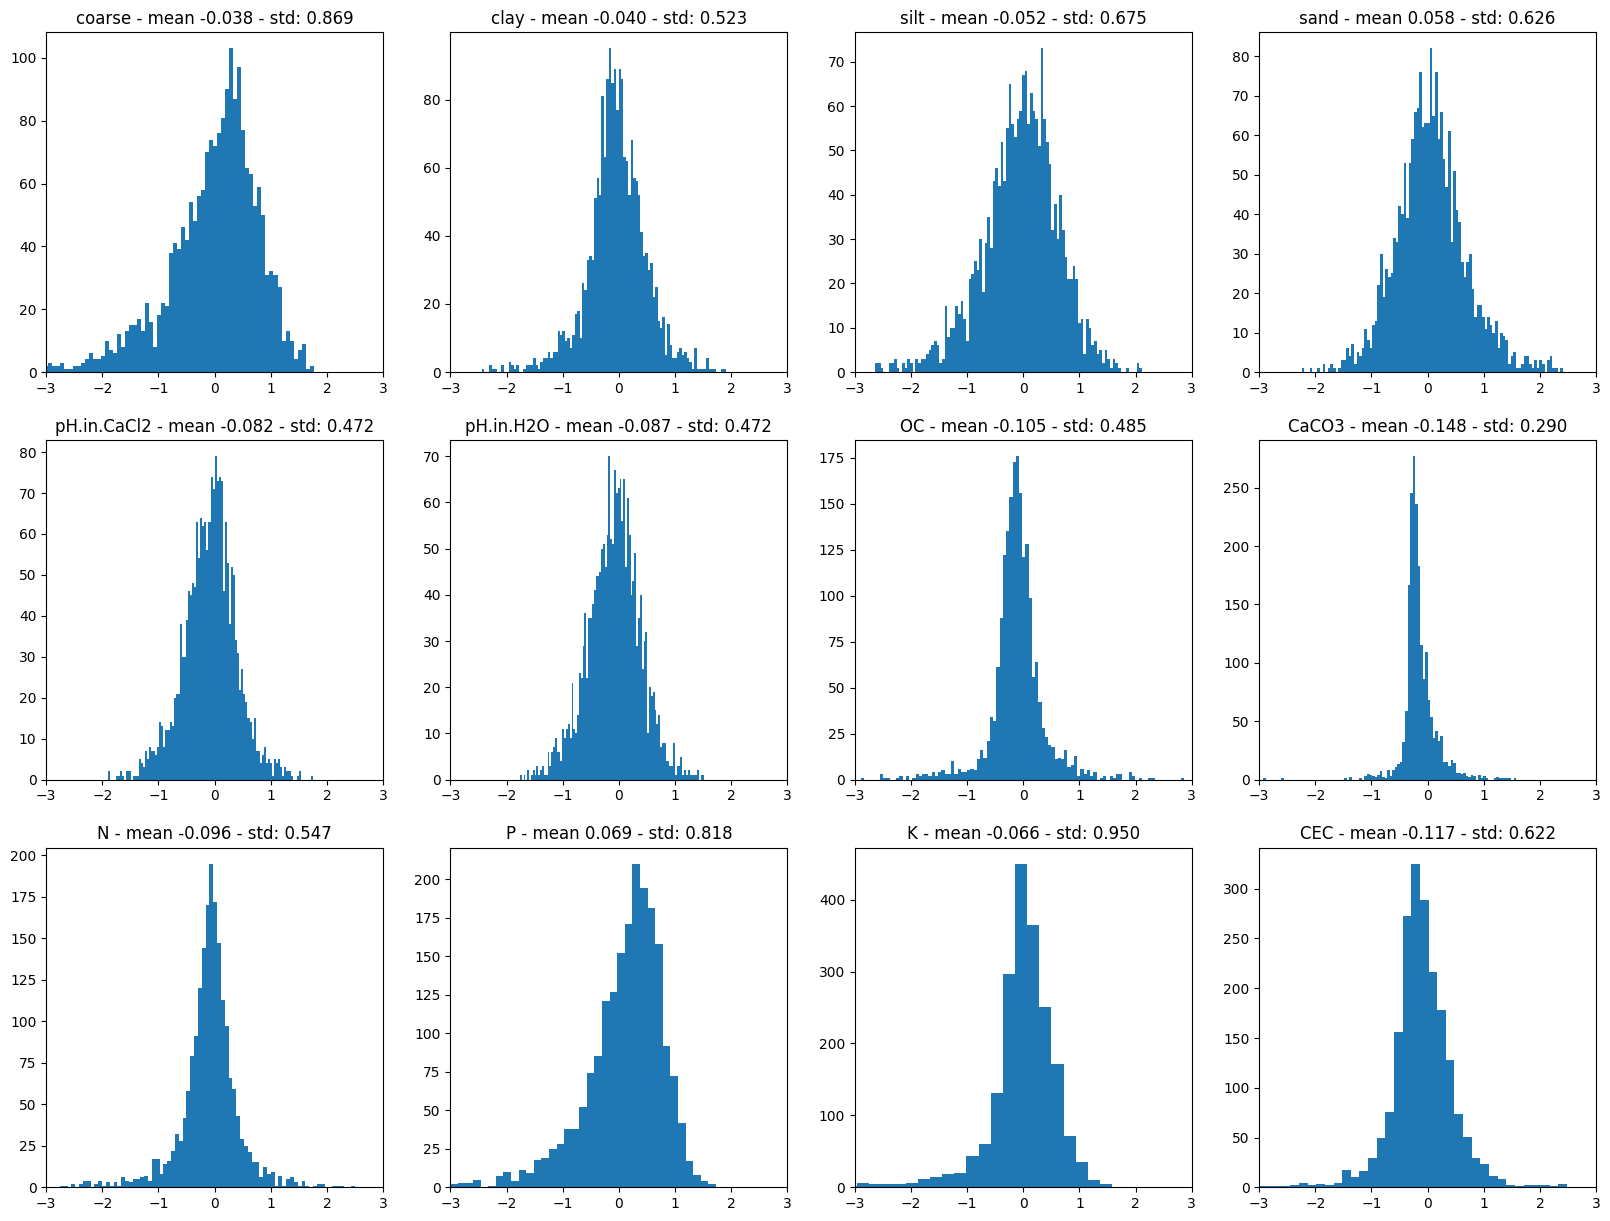

In [19]:
def compute_errors(net, dataloader):
    net.eval()
    errors = []
    for inputs, gt in dataloader:
        inputs = inputs.to(device)
        gt = gt.to(device)

        with torch.no_grad():
            out = net(inputs)
            error = (out - gt).cpu().numpy()
            errors.append(error)
    return np.concatenate(errors)

errors = compute_errors(net, testloader)

def plot_errors(errors, output_names, nr_outputs=12):
    std_dev = np.std(errors, axis=0)
    mean = np.mean(errors, axis=0)

    fig, axs = plt.subplots(3, 4, figsize=(20, 15))
    for i in range(nr_outputs):
        ax = axs[i // 4, i % 4] 
        ax.hist(errors[:, i], bins=100)
        ax.set_xlim(-3, 3)
        ax.set_title(f'{output_names[i]} - mean {mean[i]:.3f} - std: {std_dev[i]:.3f}')
    plt.show()

plot_errors(errors, output_names=output_features_names)

### Explanation of how MSE_loss works
The Mean Square Error is computed element-wise returning a matrix of errors, then based on the mean we get the mean of all errors across ALL output features

In [20]:
def compute_loss():
    """
    Computes the mean squared error (MSE) loss for multi-output regression with reduction='mean'.

    Returns:
    loss (torch.Tensor): The computed MSE loss.
    """

    # Define the criterion as Mean Squared Error (MSE) loss
    criterion = nn.MSELoss()

    # Define the predicted output tensor
    pred_output1 = torch.tensor([[1.0003, 0.9998, 0.9928],
                                 [0.9962, 0.9955, 0.9874],
                                 [0.9944, 0.9940, 0.9851],
                                 [0.9315, 0.9306, 0.9251],
                                 [0.9407, 0.9401, 0.9375],
                                 [0.9877, 0.9868, 0.9778]])

    # Define the target tensor
    target = torch.tensor([[1.0000, 1.0000, 1.0000],
                           [1.0000, 1.0000, 1.0000],
                           [1.0000, 1.0000, 1.0000],
                           [0.9400, 0.9500, 0.9500],
                           [0.9500, 0.9500, 0.9500],
                           [0.9800, 0.9800, 0.9800]])

    # Compute the MSE loss using the criterion
    loss = criterion(pred_output1, target)

    # Compute the MSE loss manually
    loss_manual = ((pred_output1 - target) ** 2).mean()

    # Compute the loss matrix
    loss_matrix = (pred_output1 - target)

    # Square the loss matrix
    loss_matrix = loss_matrix ** 2

    # Sum all the elements in the loss matrix
    sum_loss_matrix = loss_matrix.sum()

    # Get the number of elements in the loss matrix
    nr_elements = loss_matrix.numel()

    # Compute the mean of the loss matrix
    mean_loss_matrix = sum_loss_matrix / nr_elements

    # Print the loss matrix, squared loss matrix, sum of the loss matrix, number of elements, and mean of the loss matrix
    print(loss_matrix)
    print(sum_loss_matrix)
    print(nr_elements)
    print(mean_loss_matrix)

    # Print the computed MSE loss using the criterion and the manually computed MSE loss
    print(loss, loss_manual)  # = tensor(0.0001)

    return loss

compute_loss()


tensor([[9.0030e-08, 3.9989e-08, 5.1840e-05],
        [1.4440e-05, 2.0250e-05, 1.5876e-04],
        [3.1360e-05, 3.6000e-05, 2.2201e-04],
        [7.2250e-05, 3.7636e-04, 6.2001e-04],
        [8.6490e-05, 9.8009e-05, 1.5625e-04],
        [5.9289e-05, 4.6240e-05, 4.8400e-06]])
tensor(0.0021)
18
tensor(0.0001)
tensor(0.0001) tensor(0.0001)


tensor(0.0001)